In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme()

# Algoritmos Bottom-Up

O algoritmo k-means e suas variantes são técnicas *top-down*: clusterizamos os pontos encontrando **centróides** e então realizando a marcação de cada observação de acordo com o centróide mais próximo. Como vimos na aula passada, uma das **principais dificuldades** na utilização do algoritmo k-means é a **determinação de k**: como não temos informações sobre a estrutura de semelhança de nossos pontos através do algoritmo, precisamos **utilizar técnicas como PCA** ou então buscar **a melhoria de indicadores da qualidade de nossa solução de clusterização** (incluindo a usabilidade desta solução).

Hoje veremos uma nova classe de algoritmos que nos permite visualizar a estrutura de semelhança de nossas observações (HACs) ou então estimar agrupamentos a partir de outros parâmetros que não o número final de clusters (DBSCAN). 

## HACs

Algoritmos hierarquicos *agrupam* nossas observações em duas etapas:

1. Começamos calculando os grupos iniciais agrupando cada ponto com seu vizinho mais próximo;
1. Continuamos **agrupando clusters pequenos em clusters maiores**;

Este processo começa com cada ponto sendo seu próprio grupo e termina com todos os pontos pertencendo ao mesmo grupo. Para definir um algoritmo HAC precisamos de dois hiperparâmetros

### Distância

A função de distância nos permite calcular a semelhança entre dois pontos, e, desta forma, encontrar para cada ponto seu vizinho mais próximo (nearest neighbor).

### Linkage

A função de linkage defini como calcularemos a distância entre pares de clusters. Temos 4 medidas mais utilizadas em HACs:

- **Maximum or complete linkage** minimiza a **distância máxima** entre pares de clusters a serem unidos.
- **Average linkage**  minimiza a distância média entre observações de pares de clusters a serem unidos.
- **Single linkage** minimiza a distância média entre todas todas as observações de um par de cluster a ser unido.
- **Ward** minimiza a variância interna dos clusters a serem unidos.
    - Produz resultados semelhantes à k-Means.

### Utilizando HACs

Vamos utilizar algoritmos hierarquicos para clusterizar clientes com base no seu padrão de consumo.

In [3]:
tb_revenda = pd.read_csv("data/tb_revenda.csv")
tb_revenda['categoria_produto'] = tb_revenda['categoria_produto'].astype(str).map(lambda cat: cat.lower())
tb_revenda.head()

,cd_cliente,cd_pedido,cd_produto,categoria_produto,qt_vendida,receita_bruta
0,1,991533,100820,teclado,1,60.33
1,1,993099,124882,fonte,1,65.20
2,1,993099,100820,teclado,2,56.71
3,1,995369,127237,bateria,1,329.98
4,1,998477,126924,bateria,1,320.78


In [4]:
tb_cliente_produto = pd.crosstab(
    tb_revenda["cd_cliente"],
    tb_revenda["categoria_produto"],
    values=tb_revenda["receita_bruta"],
    aggfunc="sum",
    normalize="index",
)
tb_cliente_produto.head()

categoria_produto,bateria,carregador,cooler,fonte,hdd,memoria,mouse,nan,placa,ssd,teclado,tela
cd_cliente,,,,,,,,,,,,
1,0.246458,0.0,0.001547,0.053089,0.0,0.111658,0.0,0.0,0.0,0.549704,0.037545,0.000000
6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
14,0.085189,0.0,0.010198,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.254343,0.650271
32,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
49,0.823087,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.176913


In [6]:
scaler = StandardScaler()
scaler.fit(tb_cliente_produto)
tb_sca_cp = pd.DataFrame(
    scaler.transform(tb_cliente_produto), columns=tb_cliente_produto.columns, index = tb_cliente_produto.index
)
tb_sca_cp.head()

categoria_produto,bateria,carregador,cooler,fonte,hdd,memoria,mouse,nan,placa,ssd,teclado,tela
cd_cliente,,,,,,,,,,,,
1,-0.065400,-0.028091,-0.283966,-0.089796,-0.060573,1.094673,-0.061734,-0.121387,-0.244826,1.920958,-0.377684,-0.988174
6,-0.829432,-0.028091,-0.294541,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,-0.547122,1.893138
14,-0.565341,-0.028091,-0.224830,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,0.600698,0.885458
32,-0.829432,-0.028091,-0.294541,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,-0.547122,1.893138
49,1.722181,-0.028091,-0.294541,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,-0.547122,-0.478434


Vamos utilizar um **dendograma** para visualizar a estrutura de clusterização criada por um HAC:

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [9]:
Z = linkage(tb_sca_cp, method="ward")
Z

array([[1.00000000e+00, 3.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [1.80000000e+01, 2.01100000e+03, 0.00000000e+00, 3.00000000e+00],
       [8.00000000e+00, 1.30000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.84500000e+03, 4.01700000e+03, 6.03757951e+01, 4.28000000e+02],
       [4.01100000e+03, 4.01600000e+03, 6.23639543e+01, 1.58300000e+03],
       [4.01800000e+03, 4.01900000e+03, 6.44949556e+01, 2.01100000e+03]])

Text(0.5, 1.0, 'Dendograma de Clusterização')

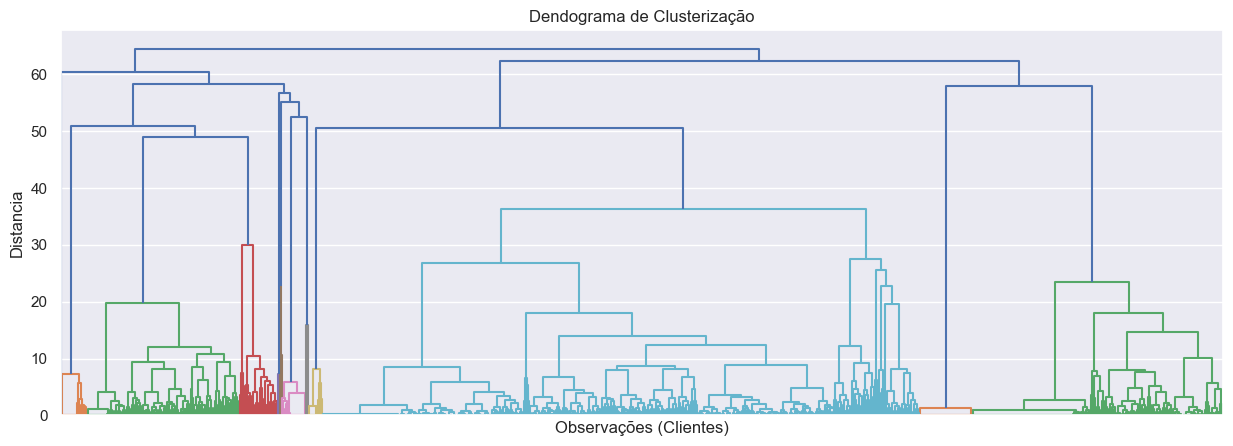

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

dendogram_ = dendrogram(Z, no_labels=True, ax=ax)

ax.set_xlabel("Observações (Clientes)")
ax.set_ylabel("Distancia")
ax.set_title("Dendograma de Clusterização")

Agora, vamos utilizar a biblioteca `sklearn` para extrair o vetor de `labels` dos nossos clusters:

In [11]:
from sklearn.cluster import AgglomerativeClustering

Vamos criar três soluções de clusterização: com 2 grupos, 3 e 6:

In [12]:
ward_2 = AgglomerativeClustering(n_clusters=2, linkage="ward")
ward_2.fit(tb_sca_cp)

ward_3 = AgglomerativeClustering(n_clusters=3, linkage="ward")
ward_3.fit(tb_sca_cp)

ward_6 = AgglomerativeClustering(n_clusters=4, linkage="ward")
ward_6.fit(tb_sca_cp)

AgglomerativeClustering(n_clusters=4)

Como nosso dataset contém mais do que 2 dimensões, vamos utilizar PCA para visualizar a nossa solução de clusterização

In [13]:
pca_cp = PCA(n_components=2)
pca_cp.fit(tb_sca_cp)

tb_pca_cp = pd.DataFrame(
    pca_cp.transform(tb_sca_cp),
    columns=["PC_" + str(i) for i in range(pca_cp.n_components_)],
)

In [15]:
tb_pca_cp

,PC_0,PC_1,ward_2,ward_3,ward_6
0,1.623740,0.145348,1,0,0
1,-1.744234,1.295091,0,2,2
2,-1.161253,0.549599,0,2,2
3,-1.744234,1.295091,0,2,2
4,-0.217296,-1.804372,0,1,1
...,...,...,...,...,...
2006,2.028233,0.993078,1,0,0
2007,-0.914571,1.061654,0,2,2
2008,0.110901,-2.470564,0,1,1
2009,1.155642,1.062935,1,0,0


In [14]:
tb_pca_cp["ward_2"] = [str(x) for x in ward_2.labels_]
tb_pca_cp["ward_3"] = [str(x) for x in ward_3.labels_]
tb_pca_cp["ward_6"] = [str(x) for x in ward_6.labels_]

Text(0.5, 0.98, 'Utilizando PCA para Visualizar Solução de Clusterização')

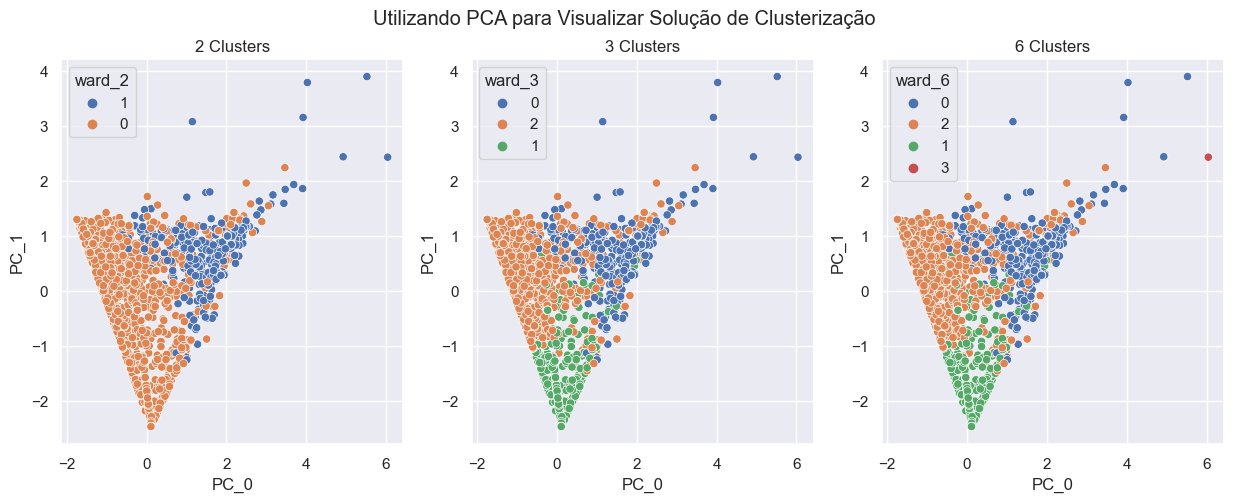

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=tb_pca_cp, x="PC_0", y="PC_1", hue="ward_2", ax=ax[0])
sns.scatterplot(data=tb_pca_cp, x="PC_0", y="PC_1", hue="ward_3", ax=ax[1])
sns.scatterplot(data=tb_pca_cp, x="PC_0", y="PC_1", hue="ward_6", ax=ax[2])
ax[0].set_title("2 Clusters")
ax[1].set_title("3 Clusters")
ax[2].set_title("6 Clusters")
fig.suptitle("Utilizando PCA para Visualizar Solução de Clusterização")

Agora, vamos interpretar a solução de três clusters:

In [17]:
tb_cliente_produto["cluster"] = ward_3.labels_.astype(str)
tb_cliente_produto.head()

categoria_produto,bateria,carregador,cooler,fonte,hdd,memoria,mouse,nan,placa,ssd,teclado,tela,cluster
cd_cliente,,,,,,,,,,,,,
1,0.246458,0.0,0.001547,0.053089,0.0,0.111658,0.0,0.0,0.0,0.549704,0.037545,0.000000,0
6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,2
14,0.085189,0.0,0.010198,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.254343,0.650271,2
32,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,2
49,0.823087,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.176913,1


Vamos adicionar uma coluna com a silhueta de nossa solução e usa-la para selecionar apenas membros dos clusters **longe** das bordas com outros clusters:

In [18]:
from sklearn.metrics import silhouette_samples

<Axes: xlabel='sil_score', ylabel='Probability'>

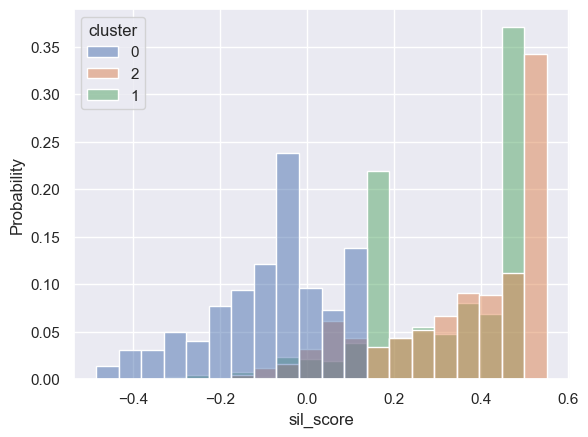

In [19]:
tb_cliente_produto["sil_score"] = silhouette_samples(tb_sca_cp, ward_3.labels_)
sns.histplot(data=tb_cliente_produto, x="sil_score", hue = "cluster", common_norm=False, stat="probability", bins=20)

In [21]:
tb_cliente_produto_sil = tb_cliente_produto[tb_cliente_produto["sil_score"] > 0]
tb_cliente_produto_sil = tb_cliente_produto_sil.drop(columns=["sil_score"])
tb_cliente_produto_sil.head()

categoria_produto,bateria,carregador,cooler,fonte,hdd,memoria,mouse,nan,placa,ssd,teclado,tela,cluster
cd_cliente,,,,,,,,,,,,,
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,2
14,0.085189,0.0,0.010198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254343,0.650271,2
32,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,2
49,0.823087,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.176913,1
51,0.321869,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124336,0.553795,2


In [23]:
tb_cliente_produto.shape

(2011, 14)

In [24]:
tb_cp_melt = (
    tb_cliente_produto_sil.reset_index()
    .melt(id_vars=["cd_cliente", "cluster"])
    .sort_values(by=["cd_cliente", "value"])
)
tb_cp_melt.head()

,cd_cliente,cluster,categoria_produto,value
0,6,2,bateria,0.0
1625,6,2,carregador,0.0
3250,6,2,cooler,0.0
4875,6,2,fonte,0.0
6500,6,2,hdd,0.0


<Axes: xlabel='categoria_produto', ylabel='value'>

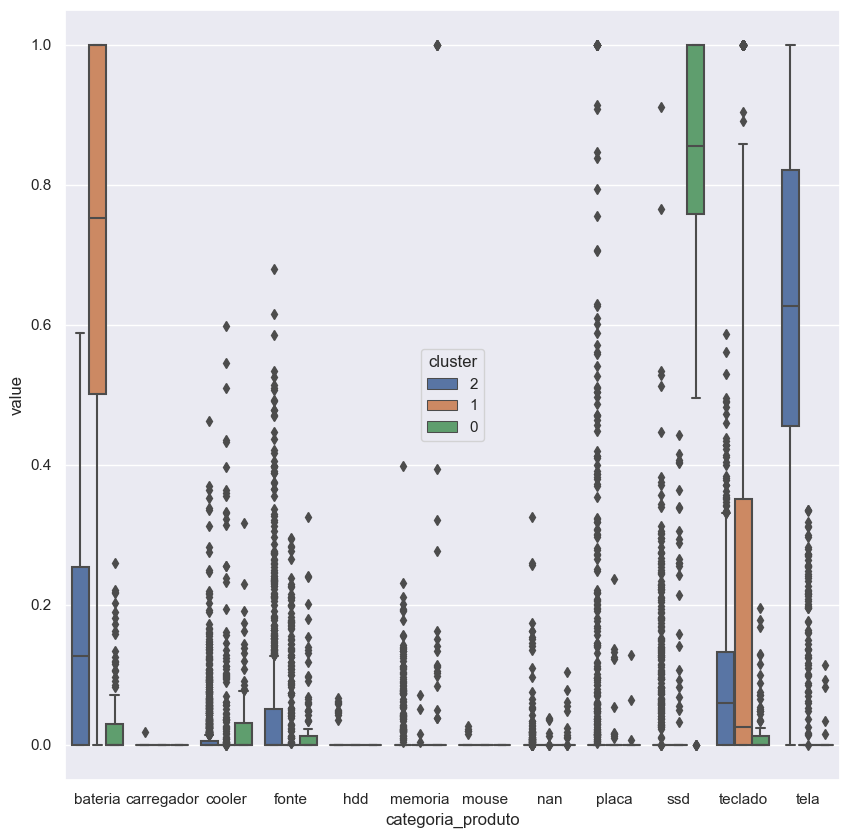

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.boxplot(data = tb_cp_melt, x = "categoria_produto", y = "value", hue = "cluster")

### Escolhendo o Linkage

Não existe forma pré-determinada de *saber* qual função de *linkage* devemos utilizar - temos que investigar diferentes solução e buscar um dendograma que seja **equilibrado** e razoavelmente simétrico.

Text(0.5, 1.0, 'Dendograma de Clusterização')

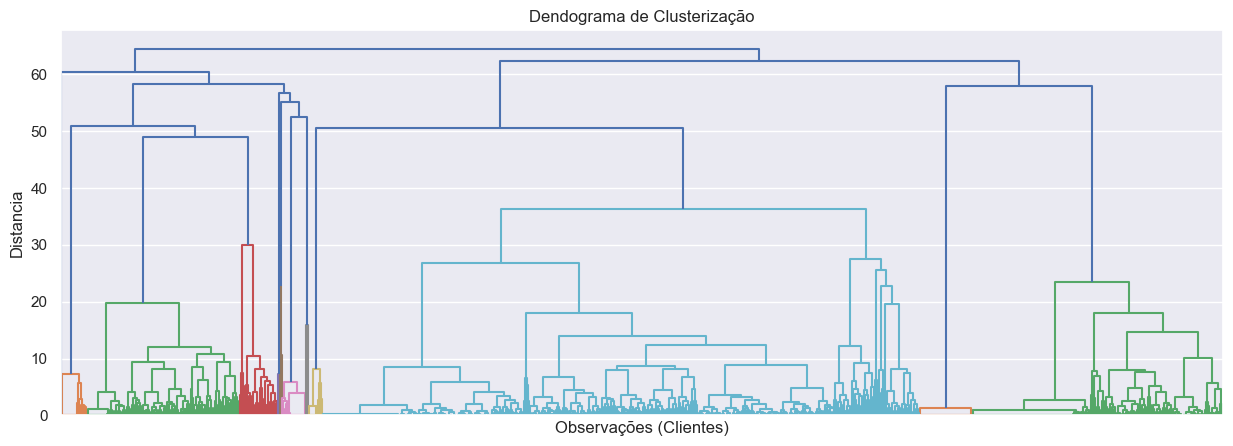

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
Z = linkage(tb_sca_cp, method="ward")
dendogram_ = dendrogram(Z, no_labels=True, ax=ax)
ax.set_xlabel("Observações (Clientes)")
ax.set_ylabel("Distancia")
ax.set_title("Dendograma de Clusterização")

## DBSCAN

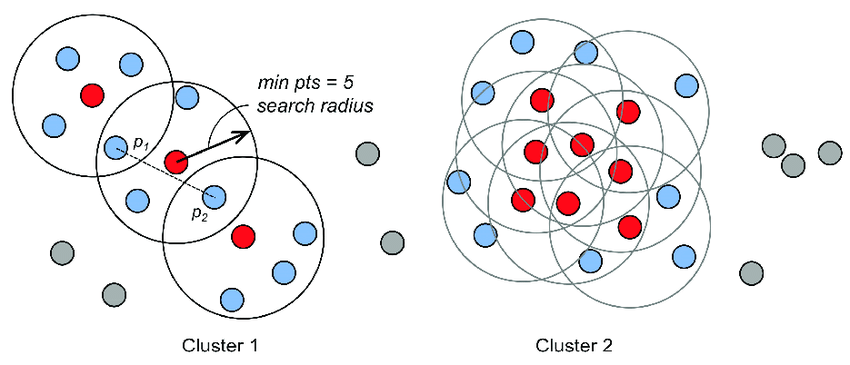

Epsilon (eps) é o raio a partir da cada ponto no qual o algoritmo vai buscar vizinhos para cada ponto do dataset. Toda vez que o algoritmo encontra pelo menos N pontos (min_samples) nesta vizinhaça o ponto é marcado como **core**.

Após marcar todos os pontos desta maneira, o algoritmo aglomera todas as vizinhanças que tenham uma intersecção em clusters. Os pontos que não se encaixaram em nenhuma vizinhança são classificados como 'outliers'.

### Utilizando DBSCAN

Uma das principais aplicações do algoritmo DBSCAN é a clusterização de pontos geográficos. Vamos utilizar este algoritmo para encontrar focos de assasinatos em Nova Iorque.

In [34]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/nypd_murder_locations.csv"
tb_murder = pd.read_csv(url, parse_dates=["CMPLNT_FR_DT"])
tb_murder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CMPLNT_NUM         261 non-null    int64         
 1   CMPLNT_FR_DT       261 non-null    datetime64[ns]
 2   LOC_OF_OCCUR_DESC  261 non-null    object        
 3   BORO_NM            261 non-null    object        
 4   ADDR_PCT_CD        261 non-null    float64       
 5   LAT                261 non-null    float64       
 6   LONG               261 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 14.4+ KB


In [35]:
tb_murder.head()

,CMPLNT_NUM,CMPLNT_FR_DT,LOC_OF_OCCUR_DESC,BORO_NM,ADDR_PCT_CD,LAT,LONG
0,255442126,2016-09-30,INSIDE,MANHATTAN,9.0,40.720450,-73.974914
1,365143806,2016-09-29,OUTSIDE,BROOKLYN,68.0,40.638668,-74.022463
2,655600478,2016-09-28,INSIDE,QUEENS,104.0,40.708228,-73.912862
3,154313364,2016-09-28,INSIDE,BROOKLYN,79.0,40.693141,-73.945860
4,225854780,2016-09-27,OUTSIDE,BRONX,46.0,40.852382,-73.913516


(-74.25538294274999, -73.70293030025, 40.50960629515, 40.90712248785)

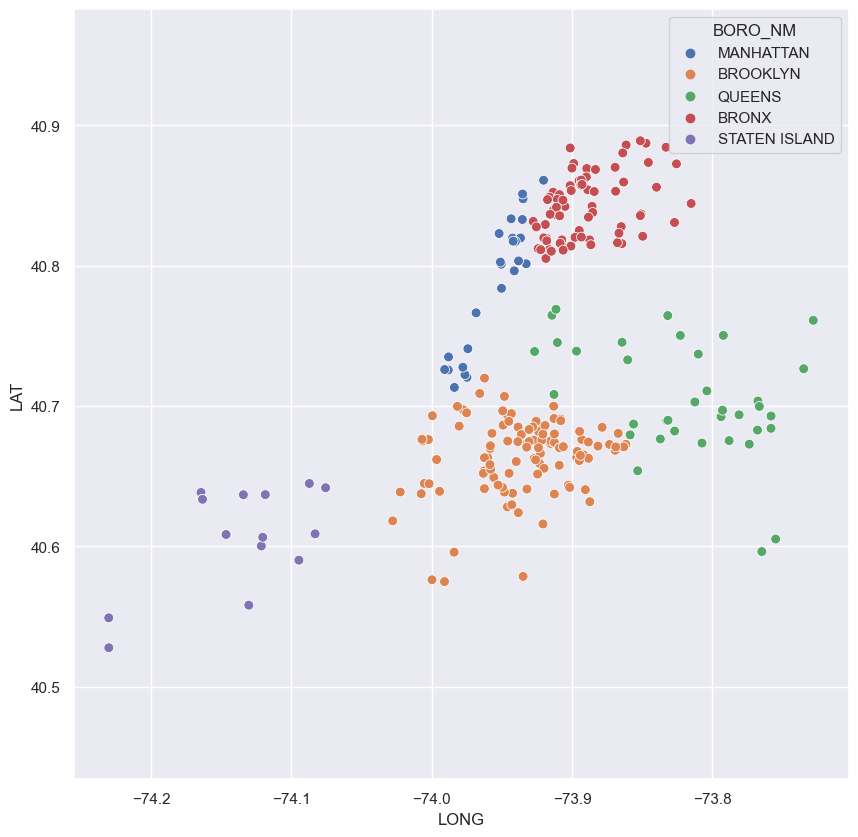

In [37]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=tb_murder, y="LAT", x="LONG", hue="BORO_NM", s=50)
plt.axis("equal")

### Transformando nossos dados

Como vamos clusterizar pontos geograficamente, podemos transformar as variáveis `LAT` e `LONG` em distâncias do ponto médio de nosso dataset.

In [38]:
tb_murder["LAT_DEMEAN"] = tb_murder["LAT"] - tb_murder["LAT"].mean()
tb_murder["LONG_DEMEAN"] = tb_murder["LONG"] - tb_murder["LONG"].mean()
tb_murder["LAT_DIST"] = (
    tb_murder["LAT_DEMEAN"] * 113819
)  # Convertendo em metros da origem
tb_murder["LONG_DIST"] = tb_murder["LONG_DEMEAN"] * 113819

(-38025.77587019969,
 24853.831446507214,
 -24778.683637962375,
 20466.211898958867)

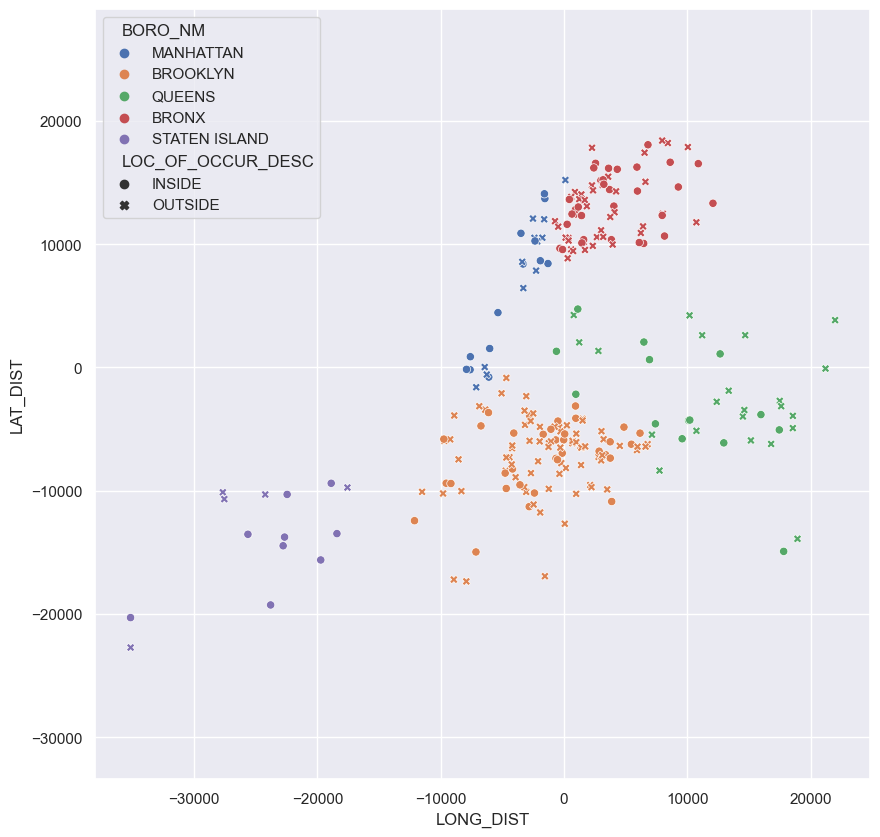

In [39]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=tb_murder,
    x="LONG_DIST",
    y="LAT_DIST",
    hue="BORO_NM",
    style="LOC_OF_OCCUR_DESC",
)
plt.axis("equal")

#### Utilizando DBSCAN

In [40]:
from sklearn.cluster import DBSCAN

In [41]:
db_fit = DBSCAN(eps=1000, min_samples=5)
db_fit.fit(tb_murder[["LAT_DIST", "LONG_DIST"]])

DBSCAN(eps=1000)

In [42]:
tb_murder["db_label"] = [str(x) for x in db_fit.labels_]
tb_murder["db_label"].value_counts()

db_label
-1    148
3      35
1      15
5      14
2      11
6      11
4      10
7       7
0       6
8       4
Name: count, dtype: int64

In [43]:
tb_murder["db_label"].value_counts(normalize=True)

db_label
-1    0.567050
3     0.134100
1     0.057471
5     0.053640
2     0.042146
6     0.042146
4     0.038314
7     0.026820
0     0.022989
8     0.015326
Name: proportion, dtype: float64

(-20000.0, 20000.0)

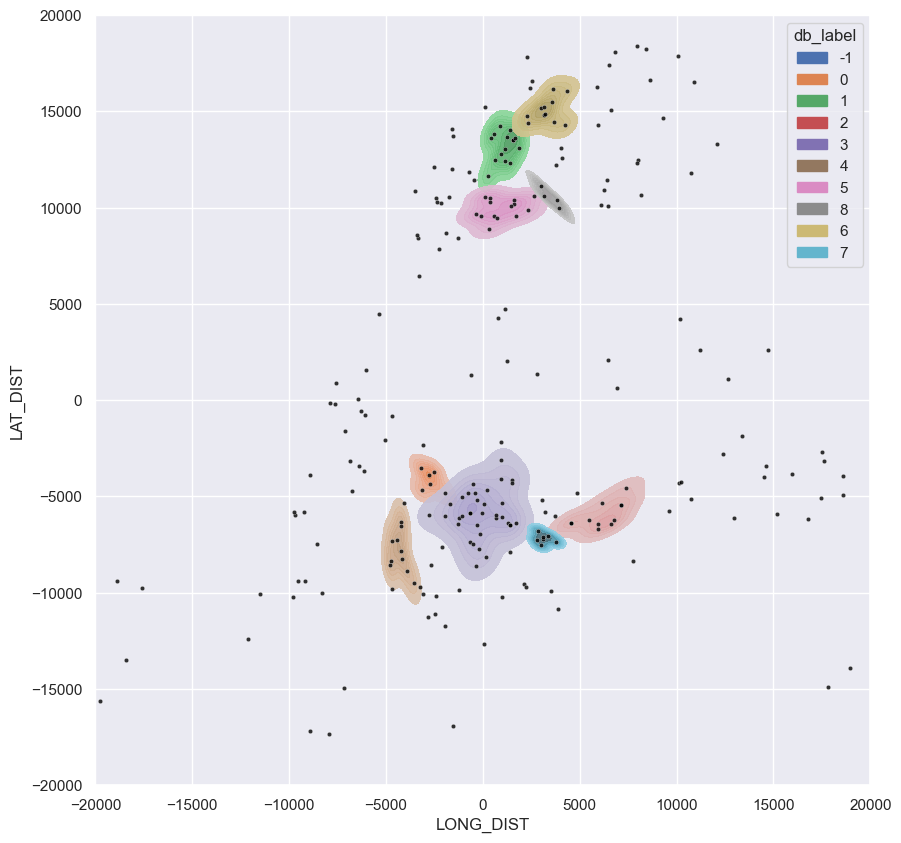

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    data=tb_murder, y="LAT_DIST", x="LONG_DIST", ax=ax, color="black", s=10, alpha=0.8, zorder = 2
)
sns.kdeplot(
    data=tb_murder[tb_murder["db_label"] != -1],
    y="LAT_DIST",
    x="LONG_DIST",
    hue="db_label",
    alpha=0.9,
    fill=True,
    ax=ax,
    zorder=1,
)
ax.set_ylim(-20000, 20000)
ax.set_xlim(-20000, 20000)

### Encontrando `eps` e `min_samples`

Em nossa primeira aplicação do DBSCAN, utilizamos o conhecimento do fenômeno a ser modelado para determinar `eps` e `min_samples`. Infelizmente isso nem sempre é possível. Em problema onde não temos uma informação precisamos de um método para encontra-los (especialmente o parâmetro `eps`).

Vamos utilizar o algoritmo de `NearestNeighbors` para visualizar a distribuição de possíveis `eps`. Ao invés de utilizar um dataset real, vamos utilizar um dataset sintético para entendermos melhor o que este algoritmo esta fazendo.

In [47]:
from sklearn.datasets import make_moons

<Axes: xlabel='X1', ylabel='X2'>

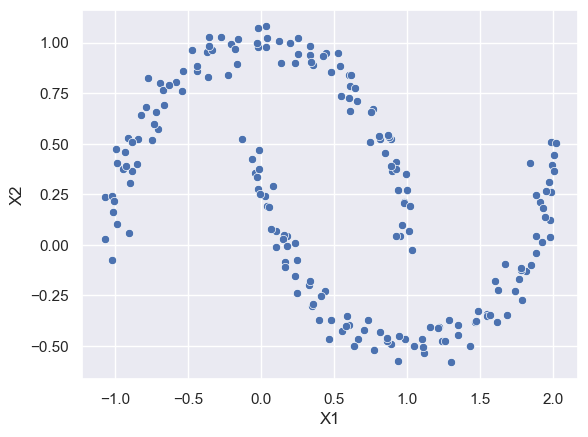

In [48]:
X, y = make_moons(200, noise=0.05, random_state=0)
tb_moon = pd.DataFrame(X, columns=["X1", "X2"])
sns.scatterplot(data=tb_moon, x="X1", y="X2")

A solução real para o problema acima pode ser encontrada utilizando `eps = 0.3` e `min_samples = 5`:

In [55]:
db = DBSCAN(eps=0.2, min_samples=5)
tb_moon["clu_dbscan"] = [str(x) for x in db.fit_predict(X)]

<Axes: xlabel='X1', ylabel='X2'>

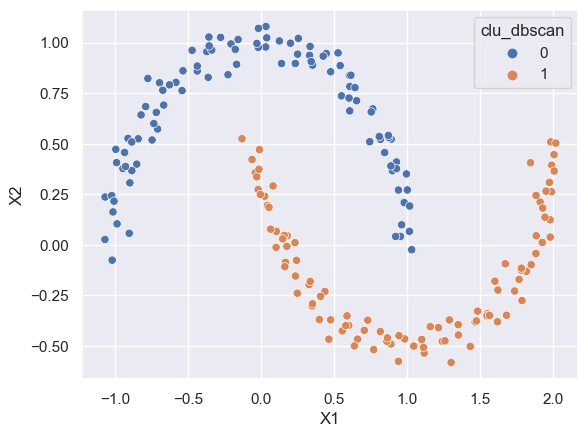

In [56]:
sns.scatterplot(data=tb_moon, x="X1", y="X2", hue="clu_dbscan")

## Utilizando NearestNeighbors

O algoritmo `NearestNeighbors` pode ser utilizado para calcular as distâncias de cada ponto de nosso dataset para seus n-vizinhos mais próximos. Essa operação é o contrário do que faz o DBSCAN: enquanto DBSCAN **procura `min_samples` em uma distância máxima `eps`**, o algoritmo NearestNeightbor **calcula a distância para os `n_neighbors` vizinhos mais próximos**!

Podemos utiliza-lo para visualizar a distribuição, para um dado `min_samples`, da **% de pontos que formarão um core** - o que nos permite buscar um ponto ótimo para `eps` dado um `min_samples`.

In [57]:
from sklearn.neighbors import NearestNeighbors

In [58]:
neighbors = 5
nbrs = NearestNeighbors(n_neighbors=neighbors)
nbrs.fit(tb_moon[["X1", "X2"]])

NearestNeighbors()

Vamos extrair as distâncias para os `5` vizinhos mais próximos de cada ponto em nosso dataset:

In [59]:
distances, indices = nbrs.kneighbors(tb_moon[["X1", "X2"]])
distances

array([[0.        , 0.01652737, 0.05772178, 0.05813506, 0.07142818],
       [0.        , 0.06272955, 0.06991381, 0.07797327, 0.08040299],
       [0.        , 0.02896776, 0.0555629 , 0.06344022, 0.08584209],
       [0.        , 0.11353429, 0.17690595, 0.18255991, 0.23840626],
       [0.        , 0.04852545, 0.05816551, 0.06394724, 0.0646936 ],
       [0.        , 0.06400715, 0.06998917, 0.08734852, 0.1100673 ],
       [0.        , 0.00602625, 0.04588674, 0.06694489, 0.07033632],
       [0.        , 0.02991413, 0.03812924, 0.06915168, 0.09470659],
       [0.        , 0.02590838, 0.02965373, 0.05165346, 0.09723572],
       [0.        , 0.02845057, 0.06923974, 0.07910702, 0.13712523],
       [0.        , 0.08137331, 0.09322398, 0.127508  , 0.13635723],
       [0.        , 0.08573221, 0.09131579, 0.10591525, 0.11661869],
       [0.        , 0.0357912 , 0.03720935, 0.04698613, 0.06394724],
       [0.        , 0.00268113, 0.05801473, 0.07297739, 0.07933809],
       [0.        , 0.0518162 , 0.

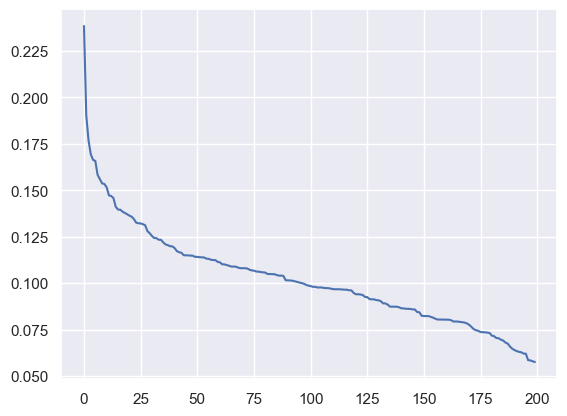

In [60]:
distance_desc = sorted(distances[:, -1], reverse=True)
plt.plot(distance_desc)

In [ ]:
# conda install conda-forge kneed
# pip install kneed

In [61]:
from kneed import KneeLocator

0.15368787728357097


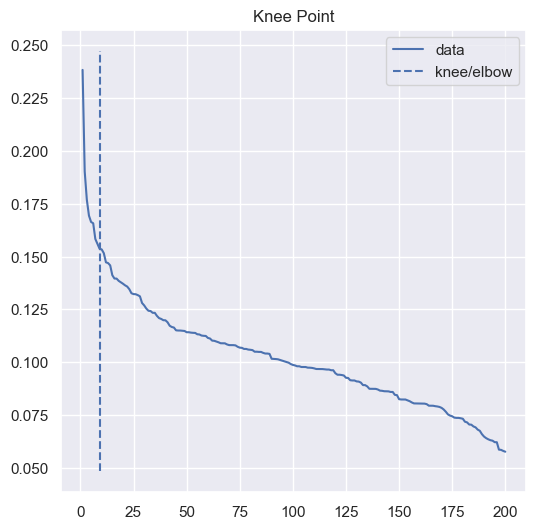

In [62]:
kneedle = KneeLocator(
    range(1, len(distance_desc) + 1),  # x values
    distance_desc,
    S=0.5,
    curve="convex",
    direction="decreasing",
)
kneedle.plot_knee()
print(kneedle.knee_y)

In [64]:
print(f"Neigh = {5}, eps = {kneedle.knee_y}, rank_eps = {kneedle.knee}")

Neigh = 5, eps = 0.15368787728357097, rank_eps = 9


In [65]:
for i in range(3, 20):
    neighbors = i
    nbrs = NearestNeighbors(n_neighbors=neighbors).fit(tb_moon[["X1", "X2"]])
    distances, indices = nbrs.kneighbors(tb_moon[["X1", "X2"]])
    distance_desc = sorted(distances[:, -1], reverse=True)
    kneedle = KneeLocator(
        range(1, len(distance_desc) + 1),  # x values
        distance_desc,
        S=0.5,
        curve="convex",
        direction="decreasing",
    )
    print(f"Neigh = {i}, eps = {kneedle.knee_y}, rank_eps = {kneedle.knee}")

Neigh = 3, eps = 0.11846042559138546, rank_eps = 8
Neigh = 4, eps = 0.14355733176591176, rank_eps = 7
Neigh = 5, eps = 0.15368787728357097, rank_eps = 9
Neigh = 6, eps = 0.19938393007658614, rank_eps = 4
Neigh = 7, eps = 0.17746549732618502, rank_eps = 12
Neigh = 8, eps = 0.1874358690548748, rank_eps = 11
Neigh = 9, eps = 0.24675987049039655, rank_eps = 6
Neigh = 10, eps = 0.20331641834526806, rank_eps = 21
Neigh = 11, eps = 0.28174087084237853, rank_eps = 11
Neigh = 12, eps = 0.33155180038382226, rank_eps = 6
Neigh = 13, eps = 0.37425697235070243, rank_eps = 5
Neigh = 14, eps = 0.32434993774209603, rank_eps = 14
Neigh = 15, eps = 0.36996410600713125, rank_eps = 11
Neigh = 16, eps = 0.4449095217466704, rank_eps = 6
Neigh = 17, eps = 0.5002126555112096, rank_eps = 3
Neigh = 18, eps = 0.48502967386824325, rank_eps = 6
Neigh = 19, eps = 0.4659414271892953, rank_eps = 13


<Axes: xlabel='X1', ylabel='X2'>

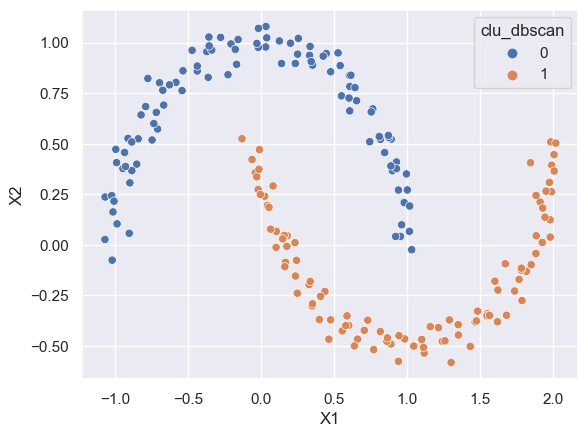

In [67]:
db = DBSCAN(eps=0.2, min_samples=6)
tb_moon["clu_dbscan"] = [str(x) for x in db.fit_predict(X)]
sns.scatterplot(data=tb_moon, x="X1", y="X2", hue="clu_dbscan")

# Notas finais

Nesta semana vimos 3 algoritmos diferentes para clusterização de observações:

* KMeans
* HACs
* DBSCAN

## KMeans

**Vantagens:** 
* algoritmo simples 
* único parâmetro

**Desvantagens:** 
* estimar o # de clusters
* não captura padrões complexos

KMeans é um bom ponto de partida para qualquer tarefa de clusterização. Devemos tomar cuidado com a estrutura de covariância dos nossos dados: se tivermos muitas variáveis correlatas, o algoritmo não irá capturar bons padrões.

**PADRÃO CAPTURADO: BLOBS**

## HACs (Modelos Hierarquicos)

**Vantagens:** 
* muito flexíveis
* nenhum parâmetro
* estima uma estrutura de clusterização hierarquica
* bottom-up

**Desvantagens:** 
* muito flexíveis
* dependem muito de conhecermos bem o problema
* custosos em termos de memória e processamento, inviáveis para dataset com mais que milhares de pontos.

Modelos hierarquicos aglomerativos (HACs) são um tipo de algoritmo *bottom-up* capaz de capturar tanto estruturas simples quanto estruturas complexas. O problema é que essa flexibilidade gera uma enorme incerteza na hora de escolhermos uma função de linkage especifica (Ward, Single, Complete...) e uma função de distância específica.

**PADRÃO CAPTURADO: Estruturas hierarquicas de clusters dentro de clusters**

## DBSCAN

**Vantagens:** 
* estima automaticamente o # de clusters
* captura não só padrões de localização mas também padrões de densidade
* não 'clusteriza' todos os pontos, detecta automaticamente outliers

**Desvantagens:** 
* parametrização complexa
* longo tempo para chegar em um resultado interessante

Os modelos de densidade (DBSCAN, OPTICS, HDBSCAN) são modelos custosos computacionalmente mas extremamente flexíveis em termos dos padrões capturados. Embora as técnicas OPTICS e HDBSCAN sejam mais automaticas, esta automatização não é sem custo.

**PADRÃO CAPTURADO: Regiões de alta densidade em nosso *feature space***